# Классификация с помощью kNN. Кластеризация K-means

### !!! ДЗ находится по тексту ноутбука: 

- в ячейке 7, 
- от ячейки 24.





Реализуем алгоритм kNN с помощью Python.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

Загрузим один из "игрушечных" датасетов из sklearn.

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [3]:
np.unique(y), y.shape

(array([0, 1, 2]), (150,))

-- имеем три целевых класса

Разделим выборку на обучающую и тестовую

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

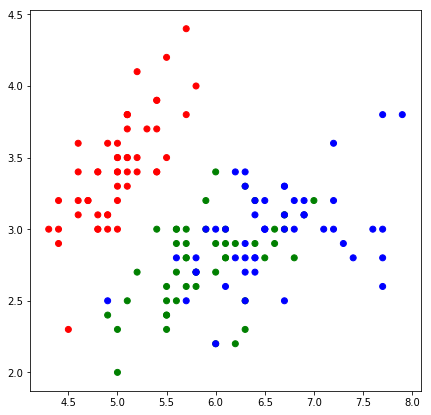

In [5]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [6]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

### К ДЗ задание 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

см. примечание с !!!

In [7]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 0.5**d[0]   ## !!! изменил вес добавки
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [8]:
classes = {class_item: 0 for class_item in set(y)}
classes

{0: 0, 1: 0, 2: 0}

Напишем функцию для вычисления точности

In [9]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [10]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [11]:
%%time
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.867
Wall time: 42.9 ms


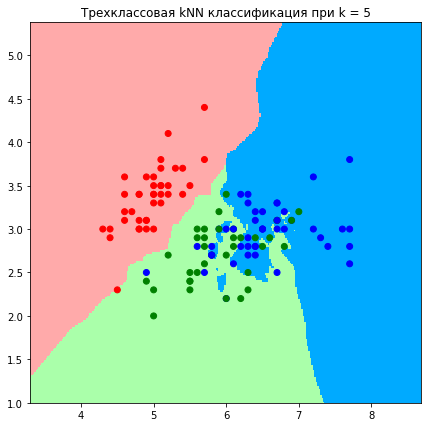

Wall time: 1min 31s


In [12]:
%%time
get_graph(X_train, y_train, k)

## Обучение без учителя. Кластеризация. K-means

### Алгоритм K-means (K-средних)

Одним из самых простых и популярных алгоритмов кластеризации является алгоритм _K-means (K-средних)_. Заключается он в следующих шагах:

1 . Выбрать количество кластеров $k$, на которые будут делиться данные.

2 . Случайным образом выбрать в пространстве данных $k$ точек $c_{k}$ (центроидов) - центров будущих кластеров.

3 . Для каждой точки из выборки посчитать, к какому из центроидов она ближе.

4 . Переместить каждый центроид в центр выборки, отнесенной к этому центроиду, определив его как среднее арифметическое всех точек кластера:

$$c_{k} = \frac{\sum_{i=1}^{l}[a(x_{i})=k]x_{i}}{\sum_{i=1}^{l}[a(x_{i}) = k]}.$$
5 . Повторить шаги 4-5 до сходимости алгоритма (обычно это оценивается по величине смещения центроида после каждого шага - сходимость означает непревышение смещения какого-то заданного значения).

Результат работы алгоритма значительно зависит от начального выбора центроидов. Существует много методик их выбора, наиболее удачным из которых считается k-means++. Он заключается в последовательном выборе начальных приближений так, что вероятность выбрать в качестве центроида следующую точку пропорциональна квадрату расстояния от нее до ближайшего центроида.

Проблемой метода также является необходимость знать число кластеров, на которые будет делиться выборка. В случае, когда это число неизвестно, вариантом ее решения может быть последовательная кластеризация на разное число кластеров (например, от 1 до 10) с последующим анализом качества работы алгоритма, например, по сумме квадратов внутрикластерных расстояний $$\sum_{k=1}^{K}\sum_{i \in C_{k}}\rho(x_{i}, c_{k})^{2}$$ - выбирается такое число кластеров, начиная с которого при увеличении количества кластеров функционал падает незначительно.

Сделаем простую реализацию алгоритма K-means своими руками на Python.

Вначале сгенерируем три облака точек с помощью инструментов `sklearn`.

In [13]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

Изобразим точки на графике.

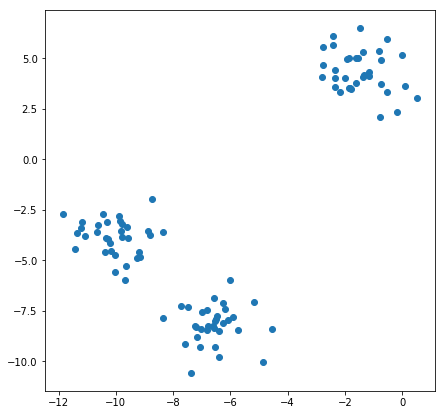

In [14]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

В качестве метрики расстояния будем использовать евклидово расстояние, функция для которого была написана ранее. В качестве центроидов выберем первые k элементов датасета. Реализуем основной цикл алгоритма.

In [15]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return centroids, classes

Напишем функцию для визуализации кластеров

In [16]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [17]:
# определим максимальное количество итераций
max_iterations = 1

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

Проверим результат алгоритма после одной итерации

In [18]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

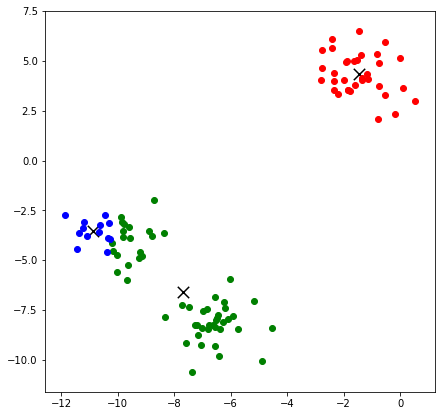

In [19]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

Проверим работу алгоритма при различном числе итераций.

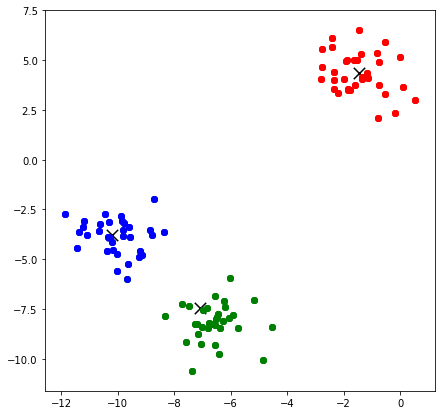

In [20]:
max_iterations = 3

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

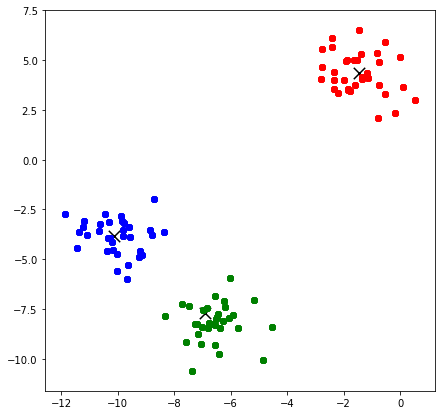

In [21]:
max_iterations = 5

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

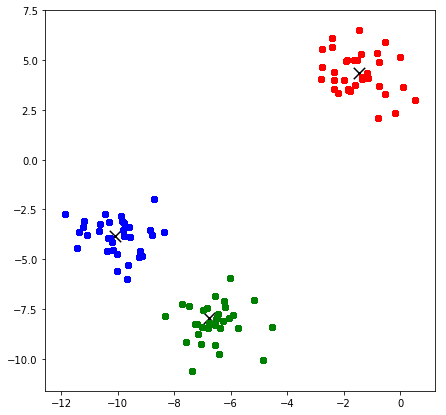

In [22]:
max_iterations = 10

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [23]:
centroids
        

[array([-1.4710815 ,  4.33721882]),
 array([-6.75829355, -7.93171616]),
 array([-10.08470763,  -3.83982512])]

Видно, как при увеличении количества итераций центроиды перемещаются в центр образующихся кластеров.

Как и говорилось ранее, метод K-means очень чувствителен к выбору начальных центров кластеров, и это является одним из его основных минусов, среди которых также сложность работы с разными формами кластеров (они, например, могут быть вытянутыми, образовывать фигуры и т.п.). В связи с этим существуют другие методы кластеризации, о которых можно прочитать в дополнительных материалах. Там же есть сравнение работы алгоритмов с кластерами различных форм.

### ДЗ задание 2*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [24]:
def avg_inner_dist(centroids, clusters):
    rr = 0
    for key in clusters:

        rr += (np.mean(np.sqrt(np.sum((clusters[key] - centroids[key])**2, axis=1))))
    return rr
            

In [25]:
avg_inner_dist(centroids, clusters)

3.505431637647677

In [26]:
max_iterations = 10
min_distance = 1e-4
dist_of = []
for k in range(1, 11):
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    dist_of.append(avg_inner_dist(centroids, clusters))

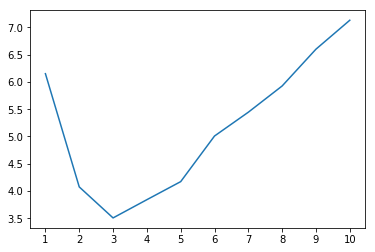

In [27]:
plt.plot(range(1, 11), dist_of)
plt.xticks(range(1,11))
plt.show()

## Дополнительные матриалы

1. Факторный, дискриминантный и кластерный анализ: Пер. с англ./Дж.-О. Ким, Ч. У. Мьюллер, У. Р. Клекка и др.; Под ред. И. С. Енюкова. — М.: Финансы и статистика, 1989.— 215 с.
2. [Об использовании мер сходства при анализе документации](http://ceur-ws.org/Vol-803/paper18.pdf)
3. [KNN Algorithm](https://medium.com/datadriveninvestor/knn-algorithm-and-implementation-from-scratch-b9f9b739c28f)
4. [Проклятие размерности](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8); ([Иллюстрация](https://www.youtube.com/watch?v=R2hQIJb0Lis))
5. [Оценка качества кластеризации](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8)
6. [Обзор алгоритмов кластеризации данных](https://habr.com/ru/post/101338/)
7. [Работа алгоритмов кластеризации на классах разной формы](https://scikit-learn.org/stable/modules/clustering.html)

## Extra

### Проблемы k-means

* необходимо заранее знать количество кластеров
* алгоритм очень чувствителен к выбору начальных центров кластеров (как вариант, на начальном этапе принимать в качестве центов самые отдаленные точки)
* не справляется с задачей, когда объект принадлежит к разным кластерам в равной степени или не принадлежит ни одному

### K-means++

<img src="data/L7_KM++.png" style="width: 1000px;">

### C-means (a.k.a. Fuzzy clustering, Soft k-means)

<img src="data/L7_CM.png" style="width: 1000px;">

## Q&A

1 - Можно ли сбалансировать классы в задаче классификации метрическими алгоритмами?

__Да, нужно!__

2 - Какова сложность алгоритмов k-means и c-means?

<img src="data/L7_Q2.png" style="width: 700px;">

## Домашнее задание

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов соседей по любому из показанных на уроке принципов.
2. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от k (взять от 1 до 10) для выборки данных из данного урока.